# Feature Selection

In [ ]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from implementations import *
from proj1_helpers import *
from misc_helpers import *
from plot_functions import *
from ml_math import *
from function_jordan import *
%load_ext autoreload
%autoreload 2

In [ ]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
y_norm = normalize(y)
tX_norm = normalize(tX)

In [ ]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)
def compute_loss_LR(b,A,x,lbd):
    return 0.5*lbd*np.linalg.norm(x, 2)**2 + fsmoothedhinge(A,b,x)
    
def cross_validation(y, x, k_fold, solver = 'LS',stoch = True,lambda_ = 0, maxit = 1):
    """return the loss of ridge regression."""
    seed = 1
    k_indices = build_k_indices(y, k_fold, seed)
    
    mse_tr = 0
    mse_te = 0
    #p = np.shape(x)[1]
    #w0 = np.zeros(p)
    
    for k in range(k_fold):
        # get k'th subgroup in test, others in train:
        test_indices = k_indices[k]
        train_indices = np.delete(k_indices,k,0).flatten()
        x_tr = x[train_indices]
        y_tr = y[train_indices]
        x_te = x[test_indices]
        y_te = y[test_indices]

        # Least squares:
        if solver == 'LS':
            w, loss = least_squares(y_tr, x_tr)
        elif solver == 'RR':
            w, loss = ridge_regression(y_tr, x_tr, lambda_)
        elif solver == 'LR':
            fx, gradf, gradsto = Oracles(y_tr, x_tr, lambda_)
            parameter = {}
            parameter['x0'] = w0
            if stoch:
                parameter['maxit'] = len(y_tr)/2
                parameter['no0functions'] = len(y_tr)
                w = SGD(fx, gradsto, parameter)
            else:
                parameter['maxit'] = maxit
                parameter['no0functions'] = len(y_tr)
                w = ADAM(fx, gradf, parameter)
            w0 = w
        else:
            raise('Error')

        # calculate the loss for train and test data: 
        
        loss_tr = compute_error(x_tr,y_tr, w)
        loss_te = compute_error(x_te,y_te, w)
    
        mse_tr += loss_tr/k_fold
        mse_te += loss_te/k_fold
        
    
    return mse_tr, mse_te, w

# Do some crazy feature selection here

In [5]:
def build_poly(x, degree, linear = False):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    if linear == False:
        D = len(x[0,:])
        N = len(x[:,0])
        new_x = np.ones((N,1)) #add bias
        if degree>=1:
            for i in range(1,degree+1):
                new_x = np.append(new_x,x**i,axis=1) 
        return new_x
    else:
        m = np.zeros((len(x),degree+1))
        for j in range(degree+1):
            m[:,j] = x**j
        return m

Here is the noise level. Everything that we add should beat this error

In [10]:
#only constant feature
tX0 = build_poly(tX,0)
N = len(y)/4
print(cross_validation(y,tX0,4, solver='LR', maxit = 5))
#only constant feature
#tX0 = build_poly(tX_norm,0)
#print(cross_validation(y,tX0,4, solver='LR', maxit = 500))

(0.34266800000000003, 0.342668, array([-0.42835219]))


In [ ]:
#Test every degree for every feature
n,p = np.shape(tX)
loss = []
good_feat = []
min_loss = np.ones(p)*10000
min_deg = np.zeros(p)
for deg in [1,2,3,4,5,6,7]:
    for i in range(p):
        print(deg,i)
        tX_ = build_poly(tX[:,i],deg, linear=True)
        loss_tr,loss_te,w = cross_validation(y,tX_,2, solver='LR')
        if loss_te<min_loss[i]:
            min_loss[i] = loss_te
            min_deg[i] = deg
        if loss_te < 0.45:
            good_feat.append((i,deg))


In [ ]:
#all of these are good features
id_min_loss = np.where(min_loss < 0.42)
id_min_loss

In [ ]:
#concatenate all good feature in tX0
tX0 = build_poly(tX,0)
for i in  id_min_loss[0]:
    deg = int(min_deg[i])
    tX0 = np.append(tX0, build_poly(tX[:,i], deg, linear=True),1)
tX0

In [ ]:
lambdas = np.logspace(-10, 0, 30)
rmse_tr = []
rmse_te = []
mse_te_min = 10000
w0 = np.ones((p))
for lambda_ in lambdas:
    mse_tr, mse_te, w = cross_validation(y,tX0,5,solver = 'RR',lambda_ = lambda_)
    rmse_tr = np.append(rmse_tr,mse_tr)
    rmse_te = np.append(rmse_te,mse_te)
    if mse_te < mse_te_min:
        w0 = w
        mse_te_min = mse_te
        

# Test for AIcrowd

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
#tX_test = normalize(tX_test)
#concatenate all good feature in tX0
tX_test_0 = build_poly(tX_test,0)
for i in  id_min_loss[0]:
    deg = int(min_deg[i])
    tX_test_0 = np.append(tX_test_0, build_poly(tX_test[:,i], deg, linear=True),1)
np.shape(tX_test_0)

In [ ]:
w0

In [ ]:
OUTPUT_PATH = 'data/feature_selection_mse_poly1.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w0, tX_test_0)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

# More advanced

Let's start from Remi's conclusion. Which is to take only the feature.\
1, 2, 4, 5, 7, 10, 11, 13, 14, 22, 23, 29, 30 (the id in feature is one less)\
First, delete where there is undefined feature. We will use:\
2, 4, 10, 11, 14, 22, 23, 30

Let's see for each, which of the degree is the best

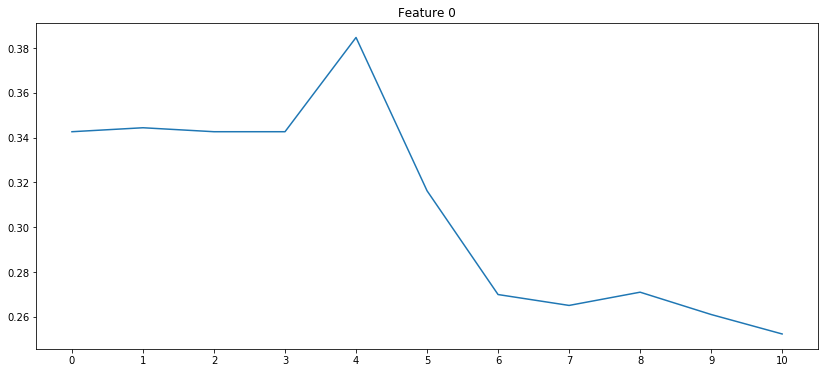

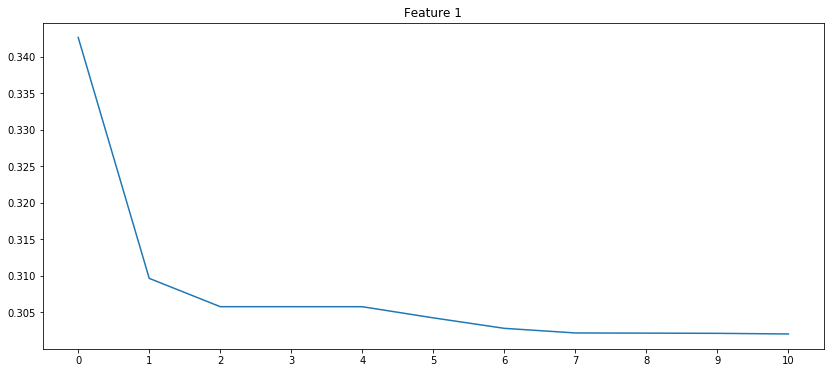

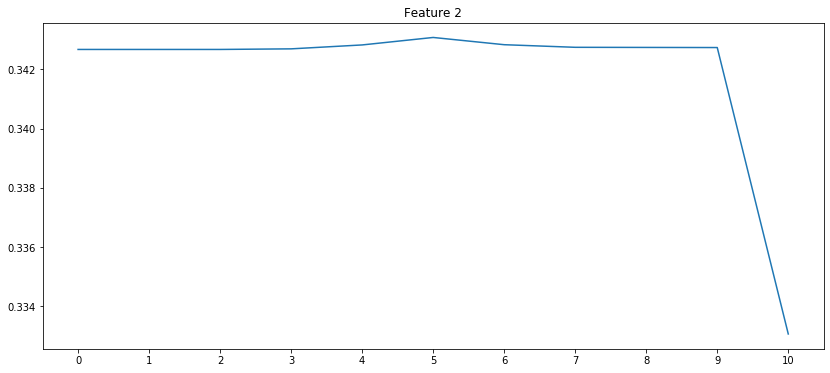

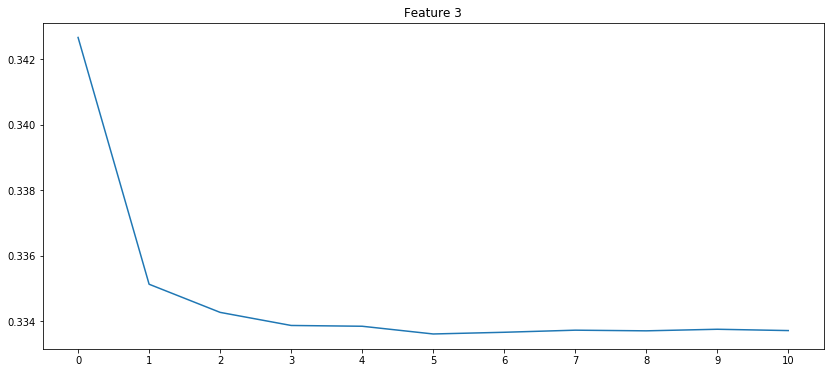

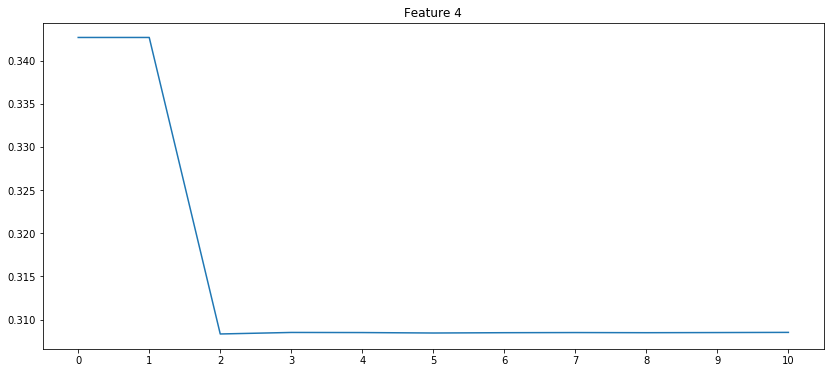

KeyboardInterrupt: 

In [12]:
#Alogrithm who will add the feature with the degree only if it improves the model.
good_feat = range(30)
degrees = [0,1,2,3,4,5,6,7,8,9,10]
losses = np.zeros((len(degrees),len(good_feat)))
#initialize model
tX_model = build_poly(tX[:,1],1,linear ='True')
for feat in good_feat:
    loss = 10000
    for deg in degrees:
        tX0 = build_poly(tX[:,feat],deg,linear ='True')
        loss_tr, loss_te, w = cross_validation(y, tX0, 2, solver = 'LS')
        if loss_te > 0.45:
            loss_te = 0.45
        losses[deg,0] = deg
        losses[deg,1] = loss_te
    plt.figure(figsize=(14, 6))
    plt.plot(losses[:,0],losses[:,1])
    plt.title('Feature %i' %feat)
    plt.xticks(losses[:,0])
    
    plt.show()

The following algorithm add a feature, elevate to a power p, to the model if it improves the model

In [7]:
#Alogrithm who will add the feature with the degree only if it improves the model.
good_feat = [1,3,9,10,13,21,22,29]
degrees = [1,2,3,4,5,6,1/2,1/3,1/4,1/5,1/6,\
          -1,-2,-3,-4,-5,-1/2,-1/3,-1/4,-1/5,-1/6]
#initialize model
tX_model = build_poly(tX[:,1],0,linear ='True')
w_model = np.ones(1)
model = np.zeros((1,2))
losses = np.array([])
losses_tr = np.array([])
for feat in good_feat:
    print(feat)
    loss = 10000
    for deg in degrees:
        tX_try = np.append(tX_model, np.array([tX_norm[:,feat]**deg]).T,axis=1)
        loss_tr, loss_te, w = cross_validation(y, tX_try, 5, solver = 'LS')
        if loss_te < loss:
            loss = loss_te
            tX_model = tX_try.copy()
            #save model
            model = np.append(model,np.array([[int(feat),deg]]),axis=0)
            losses = np.append(losses,loss)
            losses_tr = np.append(losses_tr,loss_tr)
            w_model = w
plt.figure(figsize=(14, 6))
plt.plot(losses)
plt.plot(losses_tr)
plt.title('losses')

plt.show()

#Save model
model_1 = model
loss_1 = losses[-1]
w_1 = w_model
tX_1 = tX_model

1


/Users/jordanmetz/anaconda3/envs/ML_course/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in reciprocal
  from ipykernel import kernelapp as app
/Users/jordanmetz/anaconda3/envs/ML_course/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


3


KeyboardInterrupt: 

We can see that the loss decrease well. We should use this model

# With trigonometrie

As we see that it's good functionning, let's take all feature where it cannot be singular

In [ ]:
#Alogrithm who will add the feature with the degree only if it improves the model.
good_feat = [1,2,3,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,29]
degrees = [1,2,3,4,5,6,1/2,1/3,1/4,1/5,1/6,\
          -1,-2,-3,-4,-5,-6,-1/2,-1/3,-1/4,-1/5,-1/6]
#initialize model
tX_model = build_poly(tX[:,1],0,linear ='True')
w_model = np.ones(1)
model = np.zeros((1,2))
losses = np.array([])
for feat in good_feat:
    print(feat)
    loss = 10000
    # calucate a polynomial
    for deg in degrees:
        tX_try = np.append(tX_model, np.array([tX_norm[:,feat]**deg]).T,axis=1)
        loss_tr, loss_te, w = cross_validation(y, tX_try, 5, solver = 'LS')
        if loss_te < loss:
            loss = loss_te
            tX_model = tX_try.copy()
            #save model
            model = np.append(model,np.array([[int(feat),deg]]),axis=0)
            losses = np.append(losses,loss)
            w_model = w
    #calculate arctan
    tX_try = np.append(tX_model, np.array([np.arctan(tX_norm[:,feat])]).T,axis=1)
    loss_tr, loss_te, w = cross_validation(y, tX_try, 5, solver = 'LS')
    if loss_te < loss:
        loss = loss_te
        tX_model = tX_try.copy()
        #save model
        model = np.append(model,np.array([[int(feat),'arctan']]),axis=0)
        losses = np.append(losses,loss)
        w_model = w
    #calculate sinus
    tX_try = np.append(tX_model, np.array([np.sin(tX[:,feat])]).T,axis=1)
    loss_tr, loss_te, w = cross_validation(y, tX_try, 5, solver = 'LS')
    if loss_te < loss:
        loss = loss_te
        tX_model = tX_try.copy()
        #save model
        model = np.append(model,np.array([[int(feat),'sin']]),axis=0)
        losses = np.append(losses,loss)
        w_model = w
    #calculate cosinus
    tX_try = np.append(tX_model, np.array([np.cos(tX[:,feat])]).T,axis=1)
    loss_tr, loss_te, w = cross_validation(y, tX_try, 5, solver = 'LS')
    if loss_te < loss:
        loss = loss_te
        tX_model = tX_try.copy()
        #save model
        model = np.append(model,np.array([[int(feat),'cos']]),axis=0)
        losses = np.append(losses,loss)
        w_model = w              
            
plt.figure(figsize=(14, 6))
plt.plot(losses)
plt.title('losses')

plt.show()

model_2 = model
loss_2 = losses[-1]
w_2 = w_model
tX_2 = tX_model

The following takes all features advised by Rémi

0


/Users/jordanmetz/anaconda3/envs/ML_course/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/jordanmetz/anaconda3/envs/ML_course/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  


1


/Users/jordanmetz/anaconda3/envs/ML_course/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  
/Users/jordanmetz/anaconda3/envs/ML_course/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in power
  


3
4
6
9
10
12
13
21
22
28
29


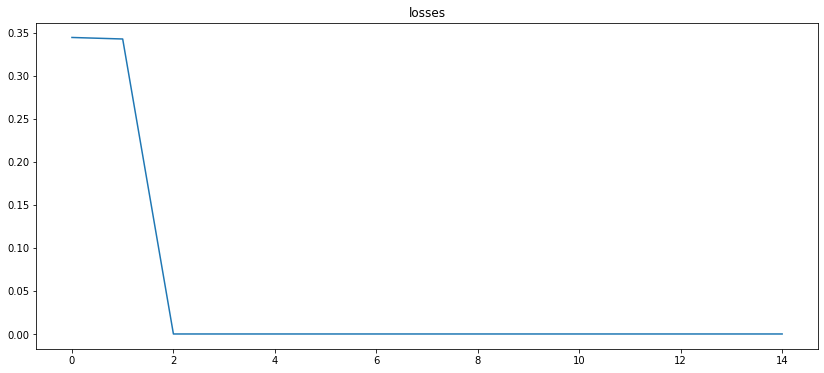

In [14]:
#Alogrithm who will add the feature with the degree only if it improves the model.
good_feat = [0, 1, 3, 4, 6, 9, 10, 12, 13, 21, 22, 28, 29]
degrees = [1,2,3,4,5,6,1/2,1/3,-1,-2,-1/2,-1/3]
#initialize model
tX_model = build_poly(tX[:,1],0,linear ='True')
w_model = np.ones(1)
model = np.zeros((1,2))
losses = np.array([])
for feat in good_feat:
    print(feat)
    loss = 10000
    # calucate a polynomial
    for deg in degrees:
        tX_try = np.append(tX_model, np.array([tX_norm[:,feat]**deg]).T,axis=1)
        loss_tr, loss_te, w = cross_validation(y, tX_try, 2, solver = 'LS')
        if loss_te < loss:
            loss = loss_te
            tX_model = tX_try.copy()
            #save model
            model = np.append(model,np.array([[int(feat),deg]]),axis=0)
            losses = np.append(losses,loss)
            w_model = w
    #calculate arctan
    tX_try = np.append(tX_model, np.array([np.arctan(tX_norm[:,feat])]).T,axis=1)
    loss_tr, loss_te, w = cross_validation(y, tX_try, 2, solver = 'LS')
    if loss_te < loss:
        loss = loss_te
        tX_model = tX_try.copy()
        #save model
        model = np.append(model,np.array([[int(feat),'arctan']]),axis=0)
        losses = np.append(losses,loss)
        w_model = w
    #calculate sinus
    tX_try = np.append(tX_model, np.array([np.sin(tX[:,feat])]).T,axis=1)
    loss_tr, loss_te, w = cross_validation(y, tX_try, 2, solver = 'LS')
    if loss_te < loss:
        loss = loss_te
        tX_model = tX_try.copy()
        #save model
        model = np.append(model,np.array([[int(feat),'sin']]),axis=0)
        losses = np.append(losses,loss)
        w_model = w
    #calculate cosinus
    tX_try = np.append(tX_model, np.array([np.cos(tX[:,feat])]).T,axis=1)
    loss_tr, loss_te, w = cross_validation(y, tX_try, 2, solver = 'LS')
    if loss_te < loss:
        loss = loss_te
        tX_model = tX_try.copy()
        #save model
        model = np.append(model,np.array([[int(feat),'sin']]),axis=0)
        losses = np.append(losses,loss)
        w_model = w              
            
plt.figure(figsize=(14, 6))
plt.plot(losses)
plt.title('losses')

plt.show()

model_3 = model
loss_3 = losses[-1]
w_3 = w_model
tX_3 = tX_model

Let's try all feature

In [ ]:
#Alogrithm who will add the feature with the degree only if it improves the model.
good_feat = range(30)
degrees = [1,2,3,1/2,1/3,1/4,\
          -1,-2,-3,,-1/2,-1/3]
#initialize model
tX_model = build_poly(tX_norm[:,1],0,linear ='True')
w_model = np.ones(1)
model = np.zeros((1,2))
losses = np.array([])
for feat in good_feat:
    print(feat)
    loss = 10000
    # calucate a polynomial
    for deg in degrees:
        tX_try = np.append(tX_model, np.array([tX_norm[:,feat]**deg]).T,axis=1)
        loss_tr, loss_te, w = cross_validation(y, tX_try, 5, solver = 'LS')
        if loss_te < loss:
            loss = loss_te
            tX_model = tX_try.copy()
            #save model
            model = np.append(model,np.array([[int(feat),deg]]),axis=0)
            losses = np.append(losses,loss)
            w_model = w
    #calculate arctan
    tX_try = np.append(tX_model, np.array([np.arctan(tX_norm[:,feat])]).T,axis=1)
    loss_tr, loss_te, w = cross_validation(y, tX_try, 5, solver = 'LS')
    if loss_te < loss:
        loss = loss_te
        tX_model = tX_try.copy()
        #save model
        model = np.append(model,np.array([[int(feat),'arctan']]),axis=0)
        losses = np.append(losses,loss)
        w_model = w
    #calculate sinus
    tX_try = np.append(tX_model, np.array([np.sin(tX[:,feat])]).T,axis=1)
    loss_tr, loss_te, w = cross_validation(y, tX_try, 5, solver = 'LS')
    if loss_te < loss:
        loss = loss_te
        tX_model = tX_try.copy()
        #save model
        model = np.append(model,np.array([[int(feat),'sin']]),axis=0)
        losses = np.append(losses,loss)
        w_model = w
    #calculate cosinus
    tX_try = np.append(tX_model, np.array([np.cos(tX[:,feat])]).T,axis=1)
    loss_tr, loss_te, w = cross_validation(y, tX_try, 5, solver = 'LS')
    if loss_te < loss:
        loss = loss_te
        tX_model = tX_try.copy()
        #save model
        model = np.append(model,np.array([[int(feat),'cos']]),axis=0)
        losses = np.append(losses,loss)
        w_model = w              
            
plt.figure(figsize=(14, 6))
plt.plot(losses)
plt.title('losses')

plt.show()

model_4 = model
loss_4 = losses[-1]
w_4 = w_model
tX_4 = tX_model

# Rebuild model for another X to evaluate the model

Choose the best model

In [ ]:
print('loss_1: ', loss_1, 'shape :', np.shape(model_1))
print('loss_2: ', loss_2, 'shape :', np.shape(model_2))
print('loss_3: ', loss_3, 'shape :', np.shape(model_3))
print('loss_4: ', loss_4, 'shape :', np.shape(model_4))

In [22]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [16]:
#choose the best model
model = model_3

#start with bias
tX_model = build_poly(tX[:,1],0,linear ='True')
tX_norm = normalize(tX)
#create model
for feat, deg in model:
    feat = int(float(feat.item()))
    print(feat,deg)
    if deg == 'arctan':
        tX_model = np.append(tX_model, np.array([np.arctan(tX_norm[:,feat])]).T,axis=1)
    elif deg == 'cos':
        tX_model = np.append(tX_model, np.array([np.cos(tX[:,feat])]).T,axis=1)
    elif deg =='sin':
        tX_model = np.append(tX_model, np.array([np.sin(tX[:,feat])]).T,axis=1)
    else :
        deg = float(deg)
        if deg != 0:
            tX_model = np.append(tX_model, np.array([tX_norm[:,feat]**deg]).T,axis=1)



0 0.0
0 1.0
0 2.0
0 0.5
1 1.0
3 1.0
4 1.0
6 1.0
9 1.0
10 1.0
12 1.0
13 1.0
21 1.0
22 1.0


/Users/jordanmetz/anaconda3/envs/ML_course/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


28 1.0
29 1.0


In [20]:
#train weights
k = 0
p = np.shape(tX_model)[1]
w0 = np.zeros(p)
min_loss = 10000
for lbd in np.logspace(-8,0,30):
    k = k+1
    print(k)
    fx , gradf,stograd = Oracles(y,tX_model,lbd)
    parameter = {}
    parameter['x0'] = w0
    parameter['maxit'] = int(len(y)/2)
    parameter['no0functions'] = len(y)
    w = SGD(fx, stograd, parameter)
    w0 = w
    loss = compute_error(y, tX_model, w)
    print(loss)
    if min_loss>loss:
        min_loss = loss
        weights = w
    

1
0.331328
2
0.331328
3
0.331328
4
0.331328
5
0.331328
6
0.331328
7
0.331328
8
0.331328
9
0.331328
10
0.331328
11
0.331328
12
0.331328
13
0.331328
14
0.331328
15
0.331328
16
0.331328
17
0.331328
18
0.331328
19
0.331328
20
0.331328
21
0.331328
22
0.331328
23
0.331328
24
0.331328
25
0.331328
26
0.331328
27
0.331328
28
0.331328
29
0.331328
30
0.331328


In [37]:
#Now Build the tX train data set

#start with bias
tX_model_test = build_poly(tX_test[:,1],0,linear ='True')
tX_test_norm = normalize(tX_test)
#create model
for feat, deg in model:
    feat = int(float(feat.item()))
    print(feat,deg)
    if deg == 'arctan':
        tX_model_test = np.append(tX_model_test, np.array([np.arctan(tX_test_norm[:,feat])]).T,axis=1)
    elif deg == 'cos':
        tX_model_test = np.append(tX_model_test, np.array([np.cos(tX_test[:,feat])]).T,axis=1)
    elif deg =='sin':
        tX_model_test = np.append(tX_model_test, np.array([np.sin(tX_test[:,feat])]).T,axis=1)
    else :
        deg = float(deg)
        if deg == 0.5:
            tX_model_test = np.append(tX_model_test, np.array([np.abs(tX_test_norm[:,feat])**deg]).T,axis=1)
        elif deg != 0:
            tX_model_test = np.append(tX_model_test, np.array([tX_test_norm[:,feat]**deg]).T,axis=1)

0 0.0
0 1.0
0 2.0
0 0.5
1 1.0
3 1.0
4 1.0
6 1.0
9 1.0
10 1.0
12 1.0
13 1.0
21 1.0
22 1.0
28 1.0
29 1.0


In [38]:
OUTPUT_PATH = 'data/feature_selection_LR_small.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_model_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)